## Human ADPKD Subclustering for submission

In [37]:
import scanpy as sc
import numpy as np
import pandas as pd
import os, sys, string
import anndata
from scipy.io import mmwrite
from collections import Counter

from typing import Tuple, Union, List, Dict, Callable
import os
import gzip
import shutil
import inspect
import h5py

import matplotlib.pyplot as plt
import anndata2ri
from harmony import harmonize

sc.set_figure_params(vector_friendly=False, fontsize=18)

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.4
-----
PIL                 8.3.1
anndata2ri          1.0.6
anyio               NA
appnope             0.1.2
astunparse          1.6.3
attr                21.2.0
babel               2.9.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.2
brotli              NA
certifi             2021.10.08
cffi                1.14.6
chardet             4.0.0
charset_normalizer  2.0.0
cloudpickle         1.6.0
colorama    

In [3]:
def makedirs(dirpath):
    if not os.path.exists(dirpath):
        os.system("mkdir "+ dirpath)

In [7]:
home      = "/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/"
datahome  = home+ "data/"
cystichome= datahome+"Cystic_signature/"
resulthome= home+ "results/"

In [ ]:
makedirs(datahome)
makedirs(cystichome)
makedirs(resulthome)

In [8]:
input_h5ad_file = "S_prepared.h5ad"

In [9]:
## read file
adata = sc.read_h5ad(datahome + input_h5ad_file)

In [10]:
adata

AnnData object with n_obs × n_vars = 26509 × 24504
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Dissociation', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'RNA_snn_res.0.8', 'RNA_snn_res.0.9', 'RNA_snn_res.1', 'seurat_clusters', 'init_assign', 'final_Ident', 'lab', 'orig.ident2', 'final_Ident2', 'ident', 'cluster_name', 'scrublet', 'treatment'
    uns: 'Phase_colors', 'X_name', 'cluster_name_colors', 'ident_colors', 'orig.ident2_colors', 'orig.ident_colors', 'rank_genes_groupscluster_name'
    obsm: 'HARMONY', 'PCA', 'UMAP'
    layers: 'logcounts'

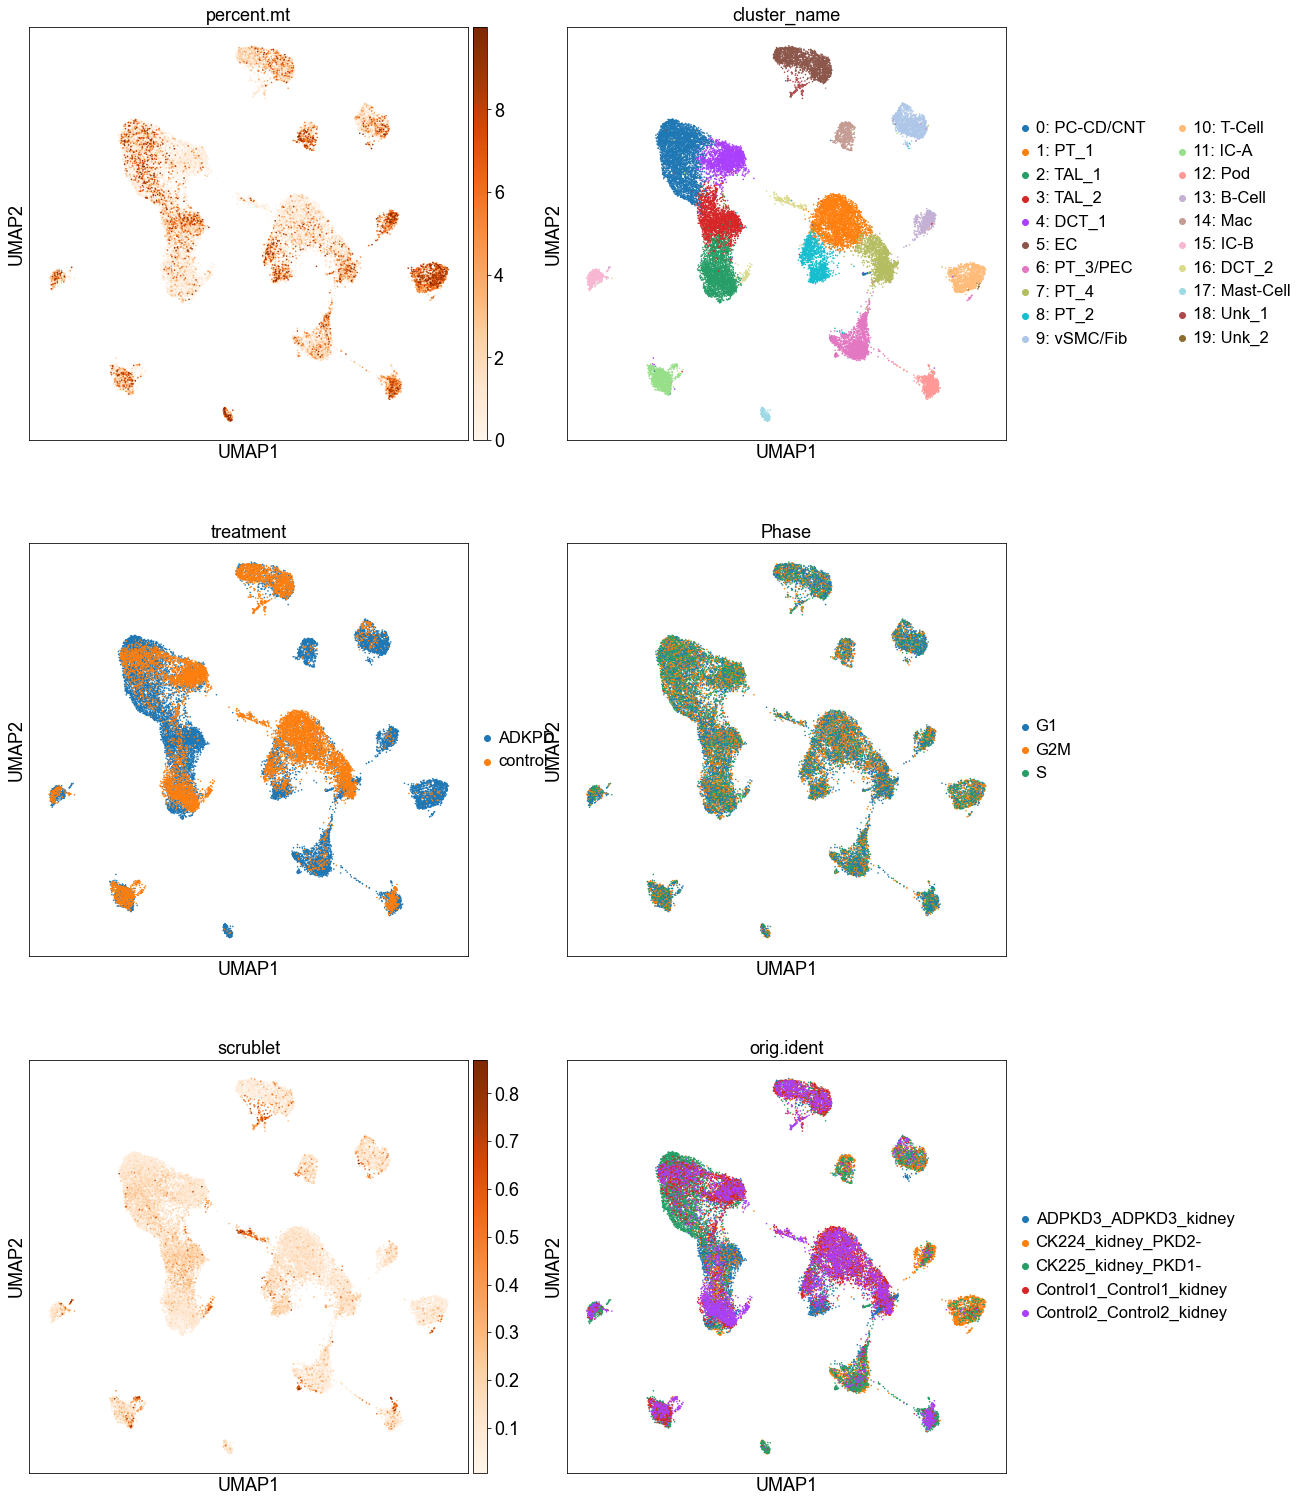

In [11]:
sc.pl.embedding(adata, basis='UMAP', color=['percent.mt', 'cluster_name', \
            'treatment', 'Phase', 'scrublet','orig.ident'], ncols=2,
                color_map='Oranges', size=10)

In [12]:
# Check normalized or counts
adata[:,'NEAT1'].X.todense()

matrix([[ 6.],
        [11.],
        [15.],
        ...,
        [ 3.],
        [ 1.],
        [ 3.]], dtype=float32)

In [14]:
cluster_key="cluster_name"

In [17]:
## major cell types
myclusters = adata.obs[cluster_key].drop_duplicates().values.tolist()
print(myclusters)

['3: TAL_2', '5: EC', '2: TAL_1', '0: PC-CD/CNT', '13: B-Cell', '14: Mac', '8: PT_2', '4: DCT_1', '1: PT_1', '9: vSMC/Fib', '7: PT_4', '6: PT_3/PEC', '18: Unk_1', '10: T-Cell', '11: IC-A', '12: Pod', '17: Mast-Cell', '15: IC-B', '19: Unk_2', '16: DCT_2']


In [18]:
## number of cells per cluster
print(Counter(adata.obs[cluster_key]))

Counter({'0: PC-CD/CNT': 4120, '1: PT_1': 2849, '2: TAL_1': 2385, '3: TAL_2': 2357, '4: DCT_1': 1852, '5: EC': 1749, '6: PT_3/PEC': 1716, '7: PT_4': 1638, '8: PT_2': 1284, '9: vSMC/Fib': 1187, '10: T-Cell': 1163, '11: IC-A': 1120, '12: Pod': 785, '13: B-Cell': 566, '14: Mac': 548, '15: IC-B': 545, '16: DCT_2': 258, '17: Mast-Cell': 225, '18: Unk_1': 130, '19: Unk_2': 32})


## Select clusters_of_interest

In [19]:
result = [i for i in myclusters if i.find('TAL')>=0]

In [20]:
result

['3: TAL_2', '2: TAL_1']

In [21]:
clusters_of_interest = result

In [22]:
## subset data on selected main cluster
bdata = adata[adata.obs[cluster_key].isin(clusters_of_interest)].copy()
bdata

AnnData object with n_obs × n_vars = 4742 × 24504
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Dissociation', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'RNA_snn_res.0.8', 'RNA_snn_res.0.9', 'RNA_snn_res.1', 'seurat_clusters', 'init_assign', 'final_Ident', 'lab', 'orig.ident2', 'final_Ident2', 'ident', 'cluster_name', 'scrublet', 'treatment'
    uns: 'Phase_colors', 'X_name', 'cluster_name_colors', 'ident_colors', 'orig.ident2_colors', 'orig.ident_colors', 'rank_genes_groupscluster_name', 'treatment_colors'
    obsm: 'HARMONY', 'PCA', 'UMAP'
    layers: 'logcounts'

In [25]:
## check per condition distribution
pd.crosstab(bdata.obs[cluster_key], bdata.obs["treatment"])

treatment,ADKPD,control
cluster_name,,
2: TAL_1,1159,1226
3: TAL_2,2123,234


In [28]:
## check per sample distribution
pd.crosstab(bdata.obs[cluster_key], bdata.obs['orig.ident'])

orig.ident,ADPKD3_ADPKD3_kidney,CK224_kidney_PKD2-,CK225_kidney_PKD1-,Control1_Control1_kidney,Control2_Control2_kidney
cluster_name,,,,,
2: TAL_1,677,293,189,351,875
3: TAL_2,1703,239,181,127,107


In [26]:
tmp_bdata = bdata.copy()

In [27]:
## get hvg
sc.pp.highly_variable_genes(tmp_bdata, n_top_genes = 2000, flavor = 'seurat_v3')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [29]:
## log-normalize
sc.pp.normalize_total(tmp_bdata, target_sum=1e4)
sc.pp.log1p(tmp_bdata)

normalizing counts per cell
    finished (0:00:00)


In [30]:
## subset on hvg
cdata = tmp_bdata[:, tmp_bdata.var.highly_variable]

In [31]:
cdata

View of AnnData object with n_obs × n_vars = 4742 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Dissociation', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'RNA_snn_res.0.8', 'RNA_snn_res.0.9', 'RNA_snn_res.1', 'seurat_clusters', 'init_assign', 'final_Ident', 'lab', 'orig.ident2', 'final_Ident2', 'ident', 'cluster_name', 'scrublet', 'treatment'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Phase_colors', 'X_name', 'cluster_name_colors', 'ident_colors', 'orig.ident2_colors', 'orig.ident_colors', 'rank_genes_groupscluster_name', 'treatment_colors', 'hvg', 'log1p'
    obsm: 'HARMONY', 'PCA', 'UMAP'
    layers: 'logcounts'

In [32]:
## regresss potential causes of technical batch-effect
sc.pp.regress_out(cdata, ['nCount_RNA', 'percent.mt'])

regressing out ['nCount_RNA', 'percent.mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


In [33]:
sc.pp.scale(cdata, max_value=10)

In [34]:
sc.tl.pca(cdata, svd_solver='arpack', n_comps = 50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [35]:
Z = harmonize(cdata.obsm['X_pca'], cdata.obs, batch_key = 'orig.ident', max_iter_harmony = 20)

	Initialization is completed.
	Completed 1 / 20 iteration(s).
	Completed 2 / 20 iteration(s).
Reach convergence after 2 iteration(s).


In [38]:
tmp_bdata.obsm['X_pca_harmony'] = Z

In [39]:
sc.pp.neighbors(tmp_bdata, n_neighbors=10, n_pcs=50, \
                use_rep = 'X_pca_harmony', metric = 'cosine', key_added = 'PC_harmony')

computing neighbors
    finished: added to `.uns['PC_harmony']`
    `.obsp['PC_harmony_distances']`, distances for each pair of neighbors
    `.obsp['PC_harmony_connectivities']`, weighted adjacency matrix (0:06:50)


In [40]:
sc.tl.umap(tmp_bdata, neighbors_key = 'PC_harmony')#, min_dist = 0.01)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [41]:
res = 0.3
sc.tl.leiden(tmp_bdata, resolution = res, key_added = 'leiden'+str(res), neighbors_key = 'PC_harmony')

running Leiden clustering
    finished: found 5 clusters and added
    'leiden0.3', the cluster labels (adata.obs, categorical) (0:00:00)


<AxesSubplot:title={'center':'leiden0.3'}, xlabel='X_umap1', ylabel='X_umap2'>

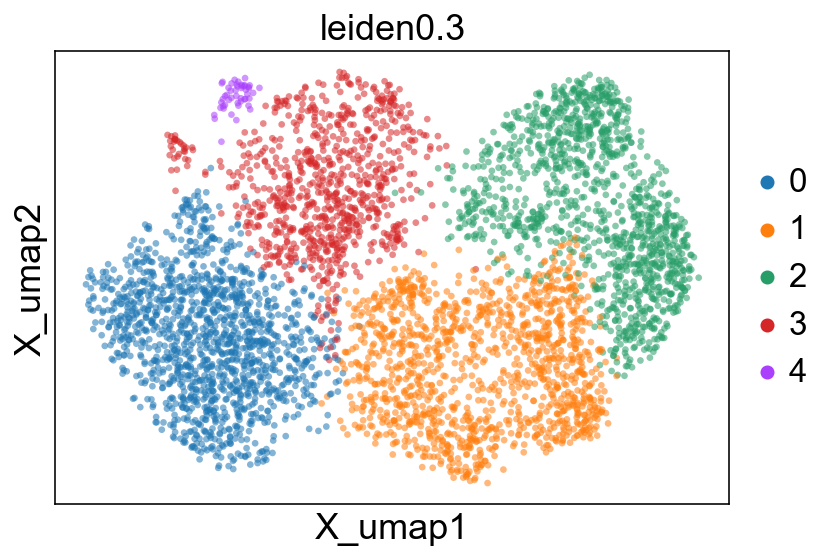

In [42]:
sc.pl.embedding(tmp_bdata, basis='X_umap', \
                color='leiden'+str(res), ax=plt.gca(), show=False, alpha=0.55, size=45)

In [43]:
min_in_group_fraction=0.1
max_out_group_fraction=0.5
min_log_fold_change=1.

sc.tl.rank_genes_groups(tmp_bdata,
                            groupby='leiden'+str(res),
                            key_added='rank_genes_groups' + str(res),
                            method='wilcoxon',
                            use_raw=False)


sc.tl.filter_rank_genes_groups(tmp_bdata,
                               groupby='leiden'+str(res),
                               key='rank_genes_groups' + str(res),
                               key_added='filter_rank_genes_groups' + str(res),
                               min_in_group_fraction=min_in_group_fraction,
                               min_fold_change=min_log_fold_change,
                               max_out_group_fraction=max_out_group_fraction,
                               use_raw=False)

ranking genes
    finished: added to `.uns['rank_genes_groups0.3']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
Filtering genes using: min_in_group_fraction: 0.1 min_fold_change: 1.0, max_out_group_fraction: 0.5


In [46]:
tmp_bdata.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,Dissociation,S.Score,G2M.Score,Phase,RNA_snn_res.0.1,RNA_snn_res.0.2,...,init_assign,final_Ident,lab,orig.ident2,final_Ident2,ident,cluster_name,scrublet,treatment,leiden0.3
AAACCCAGTCACTGAT_1,ADPKD3_ADPKD3_kidney,1204.0,832,5.420267,0.066167,-0.024496,0.032604,G2M,0,0,...,Cyst.PT_1,Cyst.PT_1,Kramann,ADPKD3_ADPKD3_kidney,ADPKD3|Cyst.PT_1,3,3: TAL_2,0.161290,ADKPD,0
AAACGAAAGCGAGTCA_1,ADPKD3_ADPKD3_kidney,1138.0,597,0.000000,0.289802,-0.019933,0.035218,G2M,1,2,...,Cyst.TAL_2,Cyst.TAL_2,Kramann,ADPKD3_ADPKD3_kidney,ADPKD3|Cyst.TAL_2,2,2: TAL_1,0.200846,ADKPD,1
AAACGAACACCGGCTA_1,ADPKD3_ADPKD3_kidney,1700.0,1038,5.921417,0.092939,0.042528,-0.000621,S,0,0,...,Cyst.PT_1,Cyst.PT_1,Kramann,ADPKD3_ADPKD3_kidney,ADPKD3|Cyst.PT_1,3,3: TAL_2,0.040388,ADKPD,0
AAACGAAGTGCAGGAT_1,ADPKD3_ADPKD3_kidney,2303.0,1351,1.707213,0.026737,0.011078,0.031865,G2M,1,1,...,Cyst.TAL_1,Cyst.TAL_1,Kramann,ADPKD3_ADPKD3_kidney,ADPKD3|Cyst.TAL_1,3,3: TAL_2,0.059961,ADKPD,3
AAACGAATCAATCAGC_1,ADPKD3_ADPKD3_kidney,2221.0,1122,1.201068,0.042921,-0.028559,-0.037827,G1,0,0,...,Cyst.PT_1,Cyst.PT_1,Kramann,ADPKD3_ADPKD3_kidney,ADPKD3|Cyst.PT_1,3,3: TAL_2,0.022517,ADKPD,0


In [51]:
num_subclusters = tmp_bdata.obs["leiden" +str(res)].nunique()
print(num_subclusters)

5


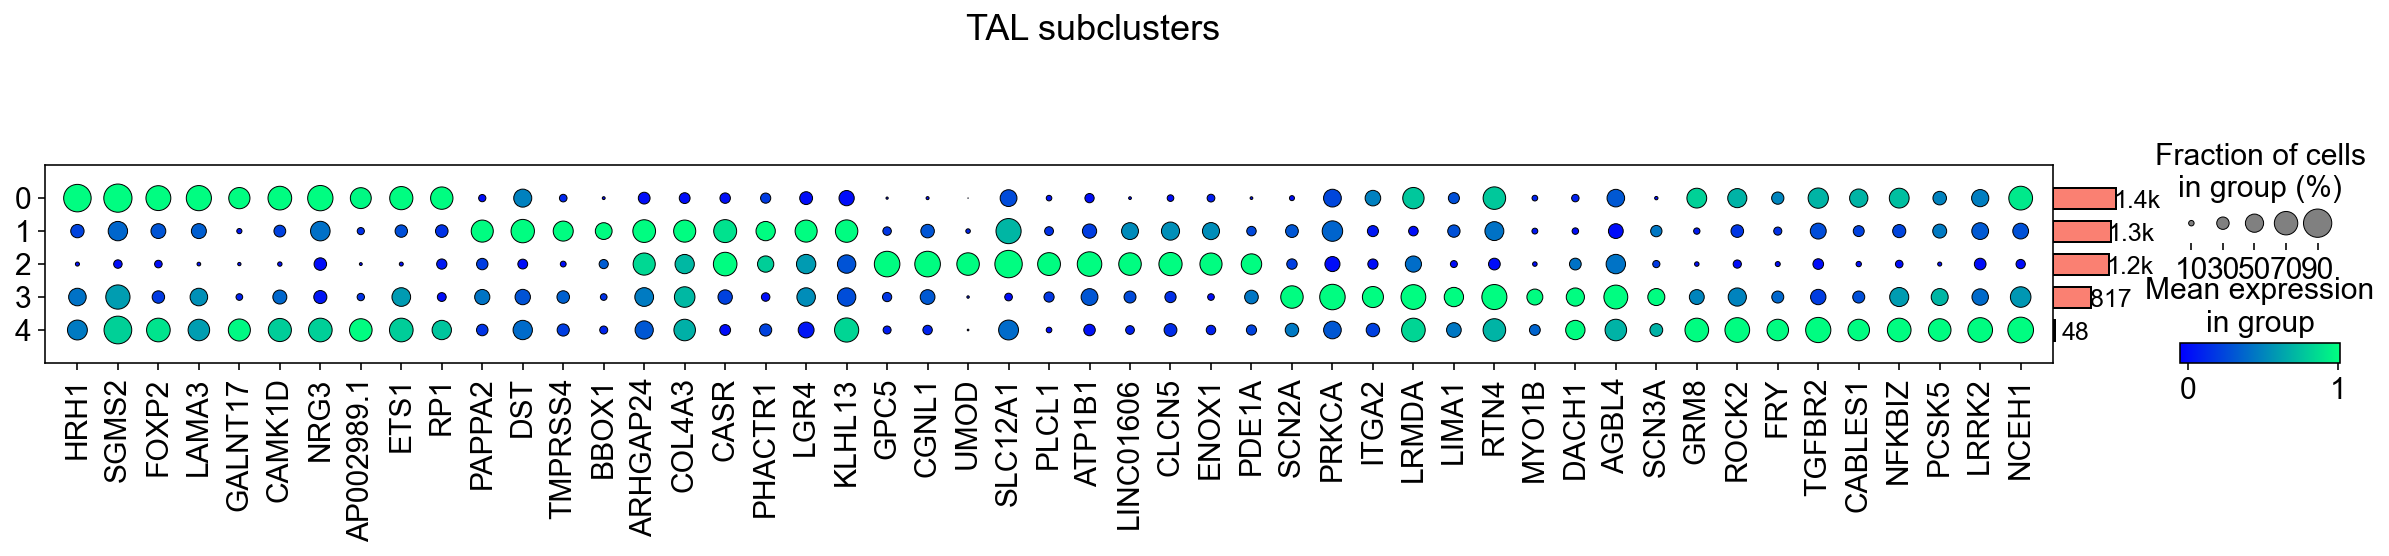

In [58]:
# marker genes

plt.rcParams.update({'font.size': 18})
n = 10

marker_key = 'rank_genes_groups' + str(res)
marker_key = 'filter_rank_genes_groups' + str(res)

marker_genes = np.array(tmp_bdata.uns[marker_key]['names'][:(n + 5)].tolist(), 
                        dtype=str).transpose()

unique_markers = []

for k in range(num_subclusters):
    i = 0
    for g in marker_genes[k, :]:
        if i < n and g not in unique_markers and g != 'nan':
            unique_markers.append(g)
            i += 1

#unique_markers.extend(["PDGFRA", "PDGFRB", "PECAM1", "SLC34A1", "VWF", "EPCAM", "VIM", "VCAM1", "HAVCR1"])

dp= sc.pl.dotplot(tmp_bdata, 
              var_names=unique_markers, 
              use_raw=False,
              groupby='leiden'+str(res),
              log=False,
              standard_scale='var',
              #color_map='Reds',
              vmin=-0.05,
              vmax=1.01,
              smallest_dot=5,
              show=False, title="TAL subclusters", return_fig=True)

dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

In [59]:
pd.crosstab(tmp_bdata.obs['orig.ident'],tmp_bdata.obs["leiden"+str(res)])

leiden0.3,0,1,2,3,4
orig.ident,,,,,
ADPKD3_ADPKD3_kidney,1249,556,151,386,38
CK224_kidney_PKD2-,117,296,13,103,3
CK225_kidney_PKD1-,11,154,24,176,5
Control1_Control1_kidney,2,101,259,115,1
Control2_Control2_kidney,2,158,784,37,1


In [60]:
# copy back over to adata
try:
    bdata.obsm['X_umap'] = tmp_bdata.obsm['X_umap']
except:
    print('Failed in copying over X_umap data')
try:
    bdata.obsm['X_pca_harmony'] = tmp_bdata.obsm['X_pca_harmony']
except:
    print('Failed in copying over X_pca_harmony data')
try:
    bdata.obs['leiden' + str(res)] = tmp_bdata.obs['leiden' + str(res)]
except:
    print('Failed in copying over leiden clustering data')
try:
    bdata.uns['rank_genes_groups' + str(res)] = tmp_bdata.uns['rank_genes_groups' + str(res)]
except:
    print('Failed in copying over rank_genes_groups data')
try:
    bdata.uns['filter_rank_genes_groups' + str(res)] = tmp_bdata.uns['filter_rank_genes_groups' + str(res)]
except:
    print('Failed in copying over filter_rank_genes_groups data')

if '__is_in_cluster__' in bdata.obs.keys():
    del bdata.obs['__is_in_cluster__']

In [61]:
bdata

AnnData object with n_obs × n_vars = 4742 × 24504
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Dissociation', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'RNA_snn_res.0.8', 'RNA_snn_res.0.9', 'RNA_snn_res.1', 'seurat_clusters', 'init_assign', 'final_Ident', 'lab', 'orig.ident2', 'final_Ident2', 'ident', 'cluster_name', 'scrublet', 'treatment', 'leiden0.3'
    uns: 'Phase_colors', 'X_name', 'cluster_name_colors', 'ident_colors', 'orig.ident2_colors', 'orig.ident_colors', 'rank_genes_groupscluster_name', 'treatment_colors', 'rank_genes_groups0.3', 'filter_rank_genes_groups0.3'
    obsm: 'HARMONY', 'PCA', 'UMAP', 'X_umap', 'X_pca_harmony'
    layers: 'logcounts'

In [63]:
# still counts or not
bdata[:,'NEAT1'].X.todense()

matrix([[ 6.],
        [15.],
        [12.],
        ...,
        [ 5.],
        [ 3.],
        [ 1.]], dtype=float32)

In [ ]:
## save object

#del bdata.uns["filter_rank_genes_groups0.1"]
#del bdata.uns["filter_rank_genes_groups0.5"]

#bdata.write(datahome + "S_prepared_subcluster_TALs.h5ad")

In [151]:
## Store potential marker gene list for cluster characterization

mytitle    = "human_adpkd_TALs_"+str(res)+"subcluster"
myclusters = bdata.obs["leiden" + str(res)].unique().tolist()

adatas = []
for mycluster in myclusters:
    tmp          = sc.get.rank_genes_groups_df(bdata, group=mycluster, key='rank_genes_groups' + str(res))
    tmp["ident"] = mycluster
    adatas.append(tmp)

mdata = pd.concat(adatas)

markerfilename = mytitle +'_logFC_stacked_marker_table.csv'

#print(mdata[mdata["pvals_adj"]<0.01].sort_values(by=["ident", "logfoldchanges"], ascending=[True, False]).head())
#print(mdata[mdata["pvals_adj"]<0.01].sort_values(by=["ident", "logfoldchanges"]).shape)
print(markerfilename)

mdata[mdata["pvals_adj"]<0.01].sort_values(by=["ident", "logfoldchanges"], ascending=[True, False])\
.to_csv(datahome + markerfilename)

human_adpkd_TALs_0.3subcluster
['0', '1', '3', '2', '4']
       names     scores  logfoldchanges          pvals      pvals_adj ident
471    INHBA   4.936873        4.999649   7.938515e-07   1.715391e-05     0
640   STEAP4   3.477936        4.878606   5.052907e-04   6.592994e-03     0
138  KIRREL3  13.132360        4.594886   2.148570e-39   2.507074e-37     0
391    MUC16   5.791984        4.557133   6.955982e-09   1.954695e-07     0
6    GALNT17  29.581442        4.290327  2.589300e-192  5.287350e-189     0
(5415, 6)
human_adpkd_TALs_0.3subcluster_logFC_stacked_marker_table.csv
